# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "clement"
ln1 = "hardy"
fn2 = "felix"
ln2 = "larrouy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_hardy_clement_and_larrouy_felix.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

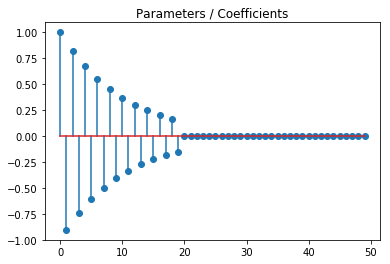

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm

def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum(0, np.abs(x) - s)
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x / (1. + s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s * np.linalg.norm(x, ord=2) ** 2 / 2.

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

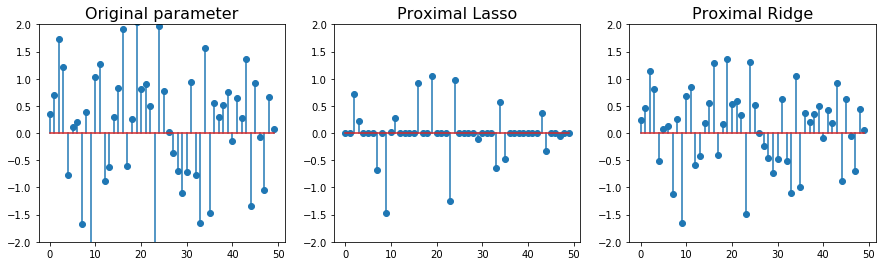

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

- For the **lasso regularization**, we can observe that the coefficients whose absolute value is smaller than **s** are equal to 0 since the proximal operator takes the maximum between 0 and |x|-s. A lot of coefficients are equal to 0, meaning that L1 norm regularization generates **sparcity**.

In [8]:
zero_coefs_lasso = len(prox_lasso(x, s=l_l1)) - np.count_nonzero(prox_lasso(x, s=l_l1))
print("Out of 50 coefficients, {0} are equal to zero.".format(zero_coefs_lasso))

Out of 50 coefficients, 33 are equal to zero.


- For the **ridge regularization**, coefficients become smaller, some are very very small but they are **not zero**. Each coefficient is indeed multiplied by $\frac{1}{1 + s}$.

In [9]:
zero_coefs_ridge = len(prox_ridge(x, s=l_l2)) - np.count_nonzero(prox_ridge(x, s=l_l2))
print("Out of 50 coefficients, {0} are equal to zero.".format(zero_coefs_ridge))

Out of 50 coefficients, 0 are equal to zero.


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [10]:
def loss_linreg(x):
    """Least-squares loss"""
    return np.linalg.norm(b - A.dot(x), ord=2) ** 2 / (2. * n_samples)

def grad_linreg(x):
    """Leas-squares gradient"""
    return - A.T.dot(b - A.dot(x)) / n_samples

def loss_logreg(x):
    """Logistic loss"""
    return np.mean(np.log(1. + np.exp(- b * A.dot(x).T)))

def grad_logreg(x):
    """Logistic gradient"""
    return np.mean(- b * A.T / (1. + np.exp(b * A.dot(x).T)), axis=1)

 ### Checking gradients

In [11]:
from scipy.optimize import check_grad

x = np.random.rand(n_features)

# linear regression
A, b = simu_linreg(coefs)
print("Linear regression: {0}".format(check_grad(loss_linreg, grad_linreg, x)))

# logistic regression
A, b = simu_logreg(coefs)
print("Logistic regression: {0}".format(check_grad(loss_logreg, grad_logreg, x)))

Linear regression: 2.95960861286e-06
Logistic regression: 1.22799538834e-07


**Comments:**  We can see that the check_grad function returns a very small value (near zero) for both linear and logistic regression. This means that the two functions to compute gradients are well implemented. 

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

### Lipschitz constants

In [12]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A, ord=2) ** 2 / n_samples
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(A, ord=2) ** 2 / (4. * n_samples)

### ISTA and FISTA

In [13]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    for k in range(n_iter + 1):
        x_new = prox_g(x - step * grad_f(x), s * step)
        x = x_new
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [14]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):
        x_new = prox_g(z - step * grad_f(z), s * step)
        t_new = (1. + np.sqrt(1. + 4 * t ** 2)) / 2.
        z = x_new + (t - 1.) / t_new * (x_new - x)
        x = x_new
        t = t_new
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [15]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [16]:
np.random.seed(10)
A, b = simu_linreg(coefs)
step_log = 1. / lip_logreg(A)
step_lin = 1. / lip_linreg(A)

# first run to find x_true
x_true, obj_true, _ = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,
                            step=step_lin, s=s, n_iter=1000, x_true=coefs, verbose=False)

x_fista_lin, obj_fista_lin, er_fista_lin = fista(x0, loss_linreg, grad_linreg,
                                                 ridge, prox_ridge, step_lin, 
                                                 s=s, n_iter=500, x_true=x_true, verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.20e+00 | 8.81e-01
      10 | 5.05e-01 | 2.56e-02
      20 | 5.05e-01 | 9.10e-03
      30 | 5.05e-01 | 3.79e-03
      40 | 5.05e-01 | 1.72e-03
      50 | 5.05e-01 | 8.16e-04
      60 | 5.05e-01 | 3.99e-04
      70 | 5.05e-01 | 2.00e-04
      80 | 5.05e-01 | 1.03e-04
      90 | 5.05e-01 | 5.37e-05
     100 | 5.05e-01 | 2.84e-05
     110 | 5.05e-01 | 1.52e-05
     120 | 5.05e-01 | 8.13e-06
     130 | 5.05e-01 | 4.37e-06
     140 | 5.05e-01 | 2.36e-06
     150 | 5.05e-01 | 1.27e-06
     160 | 5.05e-01 | 6.94e-07
     170 | 5.05e-01 | 3.81e-07
     180 | 5.05e-01 | 2.12e-07
     190 | 5.05e-01 | 1.20e-07
     200 | 5.05e-01 | 6.85e-08
     210 | 5.05e-01 | 3.98e-08
     220 | 5.05e-01 | 2.34e-08
     230 | 5.05e-01 | 1.39e-08
     240 | 5.05e-01 | 8.27e-09
     250 | 5.05e-01 | 4.96e-09
     260 | 5.05e-01 | 2.97e-09
     270 | 5.05e-01 | 1.78e-09
     280 | 5.05e-01 | 1.06e-09
     290 | 5.05e-01 | 6.28e-10
     300 | 5.0

### Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization problem using the parameters give above.

In [17]:
print('Minimum: {0}'.format(obj_fista_lin[-1]))
print('Minimizer:\n{0}'.format(x_fista_lin))

Minimum: 0.504618212748
Minimizer:
[ 0.95 -0.9   0.81 -0.72  0.63 -0.6   0.48 -0.37  0.4  -0.48  0.43 -0.29
  0.22 -0.22  0.22 -0.28  0.22 -0.17  0.17 -0.14 -0.01 -0.02  0.05 -0.05
  0.11  0.01 -0.03 -0.01  0.02 -0.02 -0.02 -0.02 -0.01  0.01  0.05  0.04
 -0.02 -0.   -0.   -0.02  0.01  0.02 -0.05 -0.01  0.04  0.01 -0.04  0.02
 -0.06  0.03]


### Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer.

Here we define a function to plot the convergences to the minimum and the minimizer, to avoid code duplicate later in the notebook.

In [18]:
def plot_convergences(er_ista, er_fista, obj_ista, obj_fista, obj_true, title, x_lim_left=100, x_lim_right=100):
    """Plot convergence of ISTA and FISTA algorithm.
    
    Parameters
    ----------
    er_ista : 'numpy.ndarray'
        Errors returned by ISTA.
    
    er_fista : 'numpy.ndarray'
        Errors returned by FISTA.
    
    obj_ista : 'numpy.ndarray'
        Objectives returned by ISTA.
        
    obj_fista : 'numpy.ndarray'
        Objectives returned by FISTA.
        
    obj_true : 'numpy.ndarray'
        Objective to reach.
    
    title : 'string'
        Plot title
        
    xlim : 'int'
        limit for the x-axis, default=1000
    """
    
    plt.figure(figsize=(16.0, 5.0))
    plt.subplot(1, 2, 1)
    plt.semilogy(er_ista, label="ISTA")
    plt.semilogy(er_fista, label="FISTA")
    plt.ylabel("Error (log scale)")
    plt.xlabel("Nb iterations")
    plt.title("Convergence to the minimizer of Ista and Fista algorithm")
    plt.xlim(0, x_lim_left)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.semilogy((obj_ista - obj_true[-1]) ** 2, label="ISTA")
    plt.semilogy((obj_fista - obj_true[-1]) ** 2, label="FISTA")
    plt.ylabel("Error (log scale)")
    plt.xlabel("Nb iterations")
    plt.title("Convergence to the minimum of Ista and Fista algorithm")
    plt.xlim(0, x_lim_right)
    plt.legend()

    plt.suptitle(title, fontsize=20)

#### 1) Convergence of logistic regression with ridge penalization

In [19]:
A, b = simu_logreg(coefs)

In [20]:
# first run to find x_true
x_true, obj_true, _= fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge,
                           step=step_log, s=s, n_iter=1000, x_true=x_true, verbose=False)

# ISTA logistic regression with ridge
x_ista_log, obj_ista_log, er_ista_log = ista(x0, loss_logreg, grad_logreg,
                                             ridge, prox_ridge, step=step_log, s=s,
                                             n_iter=400, x_true=x_true, verbose=False)

# FISTA logistic regression with ridge
x_fista_log, obj_fista_log, er_fista_log = fista(x0, loss_logreg, grad_logreg,
                                                 ridge, prox_ridge, step=step_log, s=s,
                                                 n_iter=400, x_true=x_true, verbose=False)

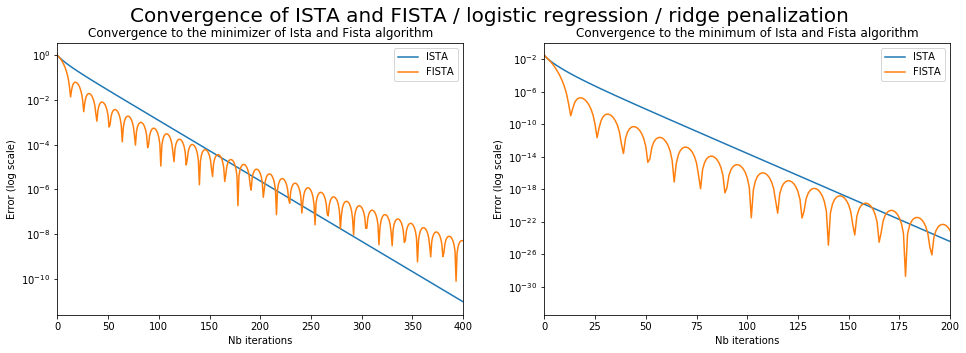

In [21]:
title = 'Convergence of ISTA and FISTA / logistic regression / ridge penalization'
plot_convergences(er_ista_log, er_fista_log, obj_ista_log, obj_fista_log,
                  obj_true, title, x_lim_left=400, x_lim_right=200)

#### 2) Convergence of logistic regression with lasso penalization

In [22]:
# first run to find x_true
x_true, obj_true, _= fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso,
                           step=step_log, s=s, n_iter=1000, x_true=x_true, verbose=False)

# ISTA logistic regression with lasso
x_ista_log, obj_ista_log, er_ista_log = ista(x0, loss_logreg, grad_logreg,
                                             lasso, prox_lasso, step=step_log, s=s,
                                             n_iter=500, x_true=x_true, verbose=False)

# FISTA logistic regression with lasso
x_fista_log, obj_fista_log, er_fista_log = fista(x0, loss_logreg, grad_logreg,
                                                 lasso, prox_lasso, step=step_log, s=s,
                                                 n_iter=500, x_true=x_true, verbose=False)

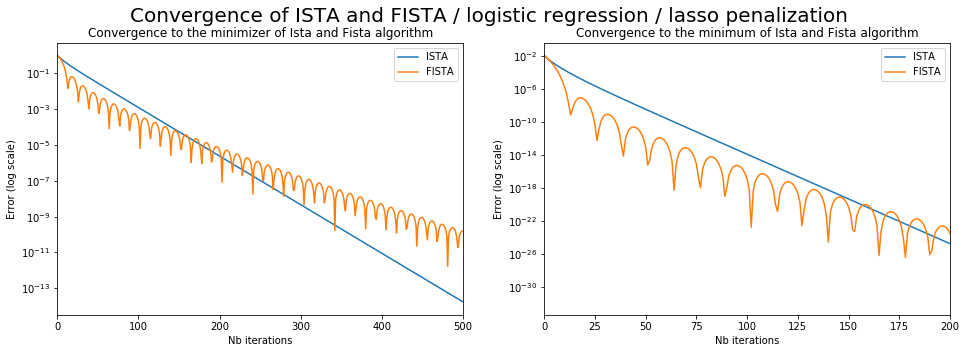

In [23]:
title = 'Convergence of ISTA and FISTA / logistic regression / lasso penalization'
plot_convergences(er_ista_log, er_fista_log, obj_ista_log, obj_fista_log,
                  obj_true, title, x_lim_left=500, x_lim_right=200)

#### 3) Convergence of linear regression with ridge penalization

In [24]:
A, b = simu_linreg(coefs)

In [25]:
# first run to find x_true
x_true, obj_true, _= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,
                           step=step_lin, s=s, n_iter=1000, x_true=x_true, verbose=False)

# ISTA linear regression with ridge
x_ista_lin, obj_ista_lin, er_ista_lin = ista(x0, loss_linreg, grad_linreg,
                                             ridge, prox_ridge, step=step_lin, s=s, n_iter=150,
                                             x_true=x_true, verbose=False)

# FISTA linear regression with ridge
x_fista_lin, obj_fista_lin, er_fista_lin = fista(x0, loss_linreg, grad_linreg,
                                                 ridge, prox_ridge, step=step_lin, s=s, n_iter=150,
                                                 x_true=x_true, verbose=False)

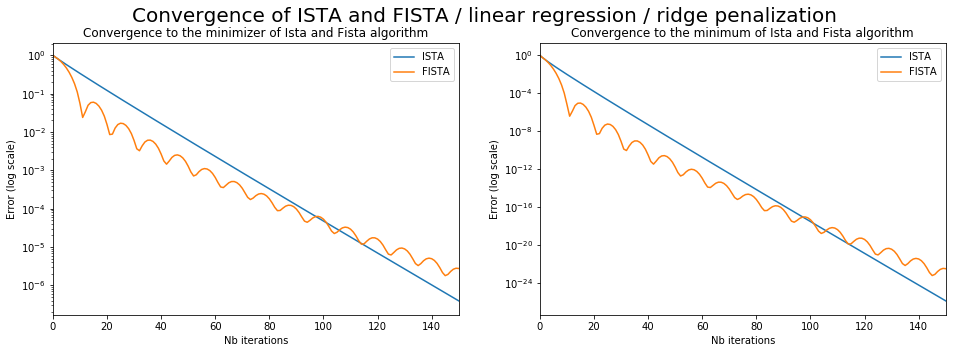

In [26]:
title = 'Convergence of ISTA and FISTA / linear regression / ridge penalization'
plot_convergences(er_ista_lin, er_fista_lin, obj_ista_lin, obj_fista_lin,
                  obj_true, title, x_lim_left=150, x_lim_right=150)

#### 4) Convergence of linear regression with lasso penalization

In [27]:
# first run to find x_true
x_true, obj_true, _= fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso,
                           step=step_lin, s=s, n_iter=1000, x_true=x_true, verbose=False)

# ISTA linear regression with lasso
x_ista_lin, obj_ista_lin, er_ista_lin = ista(x0, loss_linreg, grad_linreg,
                                             lasso, prox_lasso, step=step_lin, s=s, n_iter=150,
                                             x_true=x_true, verbose=False)

# FISTA linear regression with lasso
x_fista_lin, obj_fista_lin, er_fista_lin = fista(x0, loss_linreg, grad_linreg,
                                                 lasso, prox_lasso, step=step_lin, s=s, n_iter=150,
                                                 x_true=x_true, verbose=False)

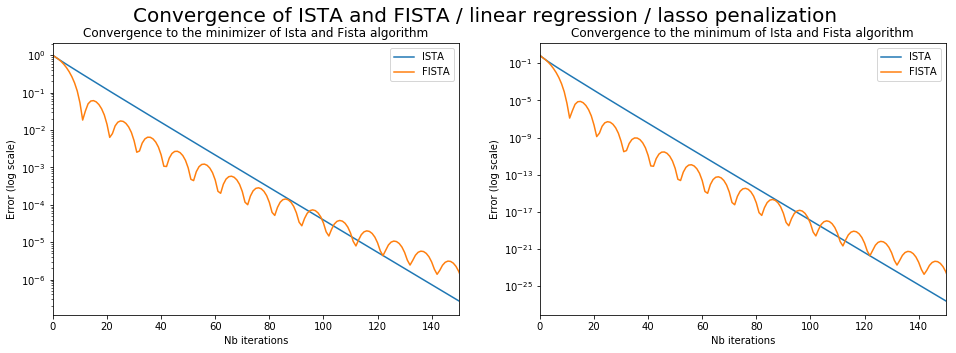

In [28]:
title = 'Convergence of ISTA and FISTA / linear regression / lasso penalization'
plot_convergences(er_ista_lin, er_fista_lin, obj_ista_lin, obj_fista_lin,
                  obj_true, title, x_lim_left=150, x_lim_right=150)

### Comments: 

We can observe that for these different cases, FISTA is converging faster than ISTA at the beginning, and then ISTA is converging faster. But FISTA is not converging in a "perfect way", as we can see the orange curve "bounces" : the error is is not getting smaller every iterations.<br>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

Here we define a function to first run FISTA in order to find x_true (the minimizer), and then run FISTA with x_true as parameter.

In [29]:
def ista_x(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50, x_true=coefs, verbose=True):
    x_true, obj_true, _ = ista(x0, f=f, grad_f=grad_f, g=g, prox_g=prox_g, step=step,
                                s=s, n_iter=1000, x_true=x_true, verbose=verbose)
    
    x_ista_log, obj_ista_log, er_ista_log = ista(x0, f=f, grad_f=grad_f, g=g, prox_g=prox_g,
                                                 step=step, s=s, n_iter=n_iter, x_true=x_true, verbose=verbose)

    return x_ista_log, obj_ista_log, er_ista_log

### Compare the solution you obtain with ista and fista with the true parameter coefs of the model

<Container object of 3 artists>

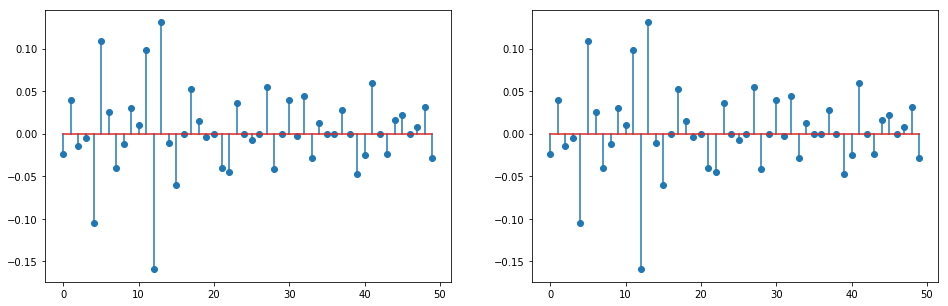

In [30]:
plt.figure(figsize=(16.0, 5.0))
plt.subplot(1, 2, 1)
plt.stem(x_fista_lin-coefs)

plt.subplot(1, 2, 2)
plt.stem(x_ista_lin-coefs)

### Comments:

- We can see that the two plots are very similar, which is a good news. This means that ISTA and FISTA algorithms are both converging to the minimum and find the same coefficients. 
- Moreover, we can see that the algorithms are not exactly converging to coefs because of the penalization (if it was the case, all the points would be on the red line).

###  Influence of the correlation of the features on the performance of the optimization algorithms

In [31]:
s = 1e-6
# list of correlation values to test influence on convergence.
l_corr = np.arange(0.2, 0.7, 0.1)

# list of colors for different correlation values.
colors_list = ['red', 'violet', 'orange', 'gold', 'limegreen', 'green']

#style of the lines
styles = ["-"] * 6 + ["--"] * 5

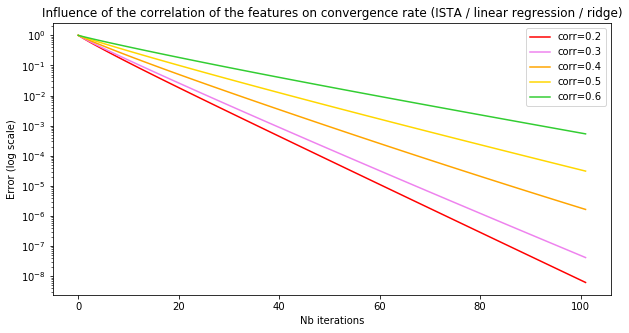

In [32]:
plt.figure(figsize=(10.0, 5.0))

for i, color in zip(l_corr, colors_list):
    A, b = simu_linreg(coefs, corr=i)
    x_ista_lin, obj_ista_lin, er_ista_lin = ista_x(x0, loss_linreg, grad_linreg,
                                                   ridge, prox_ridge, step=step_lin, s=s,
                                                   n_iter=100, x_true=coefs, verbose=False)
    plt.semilogy(er_ista_lin, color=color, label="corr={0}".format(np.round(i, decimals=1)))

plt.title("Influence of the correlation of the features on convergence rate (ISTA / linear regression / ridge)")
plt.ylabel("Error (log scale)")
plt.xlabel("Nb iterations")
plt.legend()

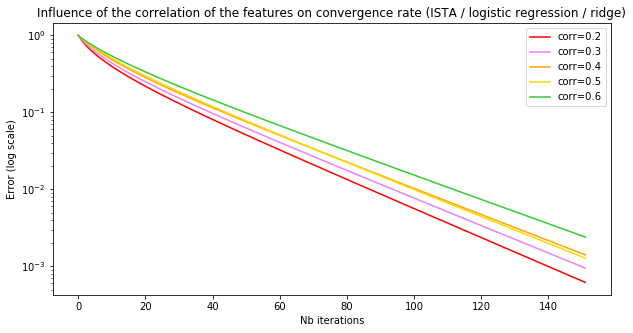

In [33]:
plt.figure(figsize=(10.0, 5.0))

for i, color in zip(l_corr, colors_list):
    A, b = simu_logreg(coefs, corr=i)
    x_ista_log, obj_ista_log, er_ista_log = ista_x(x0, loss_logreg, grad_logreg,
                                                   ridge, prox_ridge, step=step_log, s=s,
                                                   n_iter=150, x_true=coefs, verbose=False)
    plt.semilogy(er_ista_log, color=color, label="corr={0}".format(np.round(i, decimals=1)))

plt.title("Influence of the correlation of the features on convergence rate (ISTA / logistic regression / ridge)")
plt.ylabel("Error (log scale)")
plt.xlabel("Nb iterations")
plt.legend()

### Comments:

- For the two graphs above, we can see that the more the features are correlated, the more the convergence is slow. The best convergence rate is when the features are independant.

- When the correlation between the features becomes higher, the biggest eigenvalue of $A^T A$ also becomes higher and the smallest become lower. The matrix conditionning is degraded (as $s$ isn't changing). That's why the algorithm is converging slower. This is illustrated below with two examples.

In [34]:
A, b = simu_linreg(coefs, corr=0.5)
eig = np.linalg.eigvals(A.T.dot(A))
print("Biggest eigenvalue with correlation equal to 0.5: {0:.2f}".format(np.max(eig)))
print("Smallest eigenvalue with correlation equal to 0.5: {0:.2f}".format(np.min(eig)))

Biggest eigenvalue with correlation equal to 0.5: 3271.02
Smallest eigenvalue with correlation equal to 0.5: 259.97


In [35]:
A, b = simu_linreg(coefs, corr=0.9)
eig = np.linalg.eigvals(A.T.dot(A))
print("Biggest eigenvalue with correlation equal to 0.9: {0:.2f}".format(np.max(eig)))
print("Smallest eigenvalue with correlation equal to 0.9: {0:.2f}".format(np.min(eig)))

Biggest eigenvalue with correlation equal to 0.9: 15881.69
Smallest eigenvalue with correlation equal to 0.9: 40.46


### Influence of the level of ridge penalization on the performance of the optimization algorithms

In [36]:
l_s = np.arange(0, 2 , 0.4)

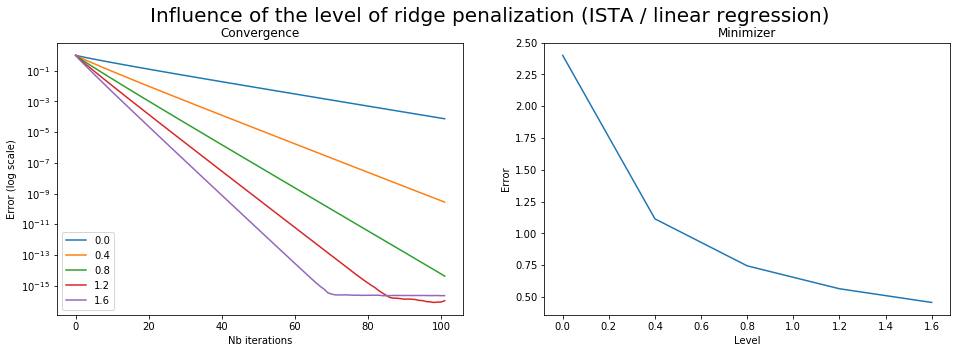

In [37]:
A, b = simu_linreg(coefs)
dist_x=[]

plt.figure(figsize=(16.0, 5.0))
plt.subplot(1, 2, 1)
plt.title("Convergence")
plt.ylabel("Error (log scale)")
plt.xlabel("Nb iterations")

for i in l_s:
    x_ista_lin, obj_ista_lin, er_ista_lin = ista_x(x0, loss_linreg, grad_linreg,
                                                   ridge, prox_ridge, step=step_lin, s=i,
                                                   n_iter=100, x_true=coefs, verbose=False)
    plt.semilogy(er_ista_lin, label=np.round(i, decimals=1))
    dist_x.append(np.linalg.norm(x_ista_lin))

plt.legend()

plt.subplot(1, 2, 2)
plt.title("Minimizer")
plt.plot(l_s, dist_x)
plt.ylabel("Error")
plt.xlabel("Level")
plt.suptitle("Influence of the level of ridge penalization (ISTA / linear regression)", fontsize=20)

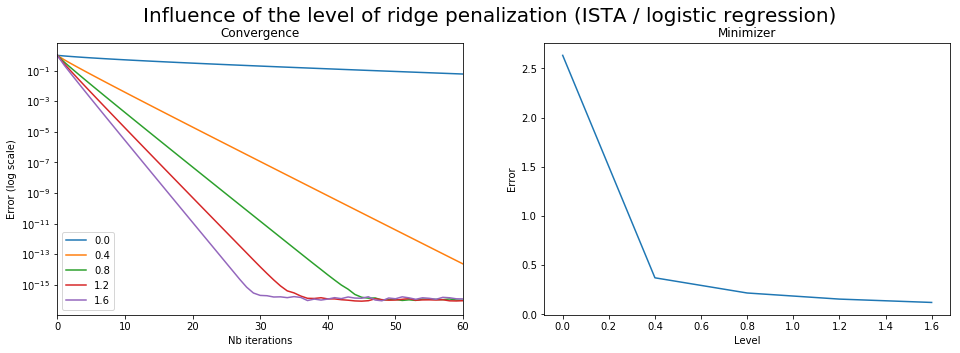

In [38]:
A, b = simu_logreg(coefs)
dist_x=[]

plt.figure(figsize=(16.0, 5.0))
plt.subplot(1, 2, 1)
plt.title("Convergence")
plt.ylabel("Error (log scale)")
plt.xlabel("Nb iterations")
plt.xlim(0, 60)

for i in l_s:
    x_ista_log, obj_ista_log, er_ista_log = ista_x(x0, loss_logreg, grad_logreg,
                                                   ridge, prox_ridge, step=step_log, s=i,
                                                   n_iter=100, x_true=coefs, verbose=False)
    plt.semilogy(er_ista_log, label=np.round(i, decimals=1))
    dist_x.append(np.linalg.norm(x_ista_log))
    
plt.legend()


plt.subplot(1, 2, 2)
plt.title("Minimizer")
plt.plot(l_s, dist_x)
plt.ylabel("Error")
plt.xlabel("Level")
plt.suptitle("Influence of the level of ridge penalization (ISTA / logistic regression)", fontsize=20)

### Comments:
- The left graph is illustrating the different convergence rates according to level of ridge penalization. The more the level is important, the fastest the algorithm converges in both cases (linear regression and logistic regression). The eigenvalue is again the reason, take a biggest s has the effect of obtaining biggest eigenvalue, the maxtrix conditionning is better and so the algorithms are converging faster. 

**Note**: The error is stabilizing at approximately $10^{-16}$ because this is the zero of the computer.

- The right one shows how the norm of the solution changes when the level changes. We can see that the higher the level of penalization, the lowest is the norm of the solution, the norm of the solution is converging to 0 (this is coherent with the effect of a regularization).

### Performance of the optimization algorithms for ridge and lasso penalizations

In [39]:
s = 1e-2

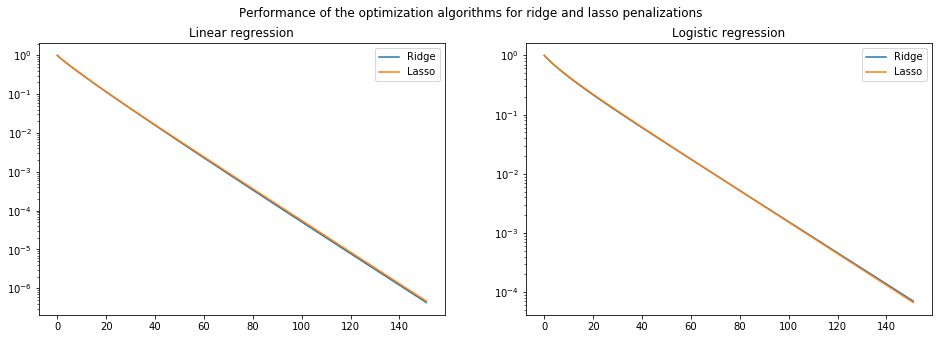

In [40]:
plt.figure(figsize=(16.0, 5.0))

A, b = simu_linreg(coefs)
x_ista_lasso, obj_ista_lasso, er_ista_lasso = ista_x(x0, loss_linreg, grad_linreg,
                                                     lasso, prox_lasso, step=step_lin, s=s,
                                                     n_iter=150, x_true=x_true, verbose=False)

x_ista_ridge, obj_ista_ridge, er_ista_ridge = ista_x(x0, loss_linreg, grad_linreg,
                                                     ridge, prox_ridge, step=step_lin, s=s,
                                                     n_iter=150, x_true=coefs, verbose=False)

plt.subplot(1,2,1)
plt.title("Linear regression")
plt.semilogy(er_ista_ridge, label="Ridge")
plt.semilogy(er_ista_lasso, label="Lasso")
plt.legend()

A, b = simu_logreg(coefs)
x_ista_lasso, obj_ista_lasso, er_ista_lasso = ista_x(x0, loss_logreg, grad_logreg,
                                                     lasso, prox_lasso, step=step_log, s=s,
                                                     n_iter=150, x_true=x_true, verbose=False)

x_ista_ridge, obj_ista_ridge, er_ista_ridge = ista_x(x0, loss_logreg, grad_logreg,
                                                     ridge, prox_ridge, step=step_log,
                                                     s=s, n_iter=150, x_true=coefs, verbose=False)

plt.subplot(1,2,2)
plt.title("Logistic regression")
plt.semilogy(er_ista_ridge, label="Ridge")
plt.semilogy(er_ista_lasso, label="Lasso")
plt.legend()
plt.suptitle("Performance of the optimization algorithms for ridge and lasso penalizations")

### Comments

For both linear and logistic regression, the convergence rate is nearly the same, when we apply ridge penalization or lasso penalization.